<a href="https://colab.research.google.com/github/ngcheeyuan/Learner-s-Repo-for-Tensorflow/blob/main/04_transfer_learing_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with Tensorflow part 1 : Feature Extraction

Leverage a working model's existing architecture and learned patterns

2 main benefits:
1. Can leverage an existing NN architecture proven to work on problem similar to ours.
2. Can leverage a working NN which has already learned patterns on similar data to our own, then we can adata those patterns to our own data

reference : https://github.com/mrdbourke/tensorflow-deep-learning

In [ ]:
!nvidia-smi

Tue Jan 11 11:04:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2022-01-11 11:06:42--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 172.217.214.128, 108.177.111.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.2’

10_food_classes_10_ 100%[===================>] 160.74M   209MB/s    in 0.8s    

2022-01-11 11:06:43 (209 MB/s) - ‘10_food_classes_10_percent.zip.2’ saved [168546183/168546183]



In [ ]:
# HOw many images in each folder?

import os

for dirpath,dirnames,filenames in os.walk('10_food_classes_10_percent'):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.")

There are 2 directories and 0 images in 10_food_classes_10_percent.
There are 10 directories and 0 images in 10_food_classes_10_percent/test.
There are 0 directories and 250 images in 10_food_classes_10_percent/test/sushi.
There are 0 directories and 250 images in 10_food_classes_10_percent/test/grilled_salmon.
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_wings.
There are 0 directories and 250 images in 10_food_classes_10_percent/test/fried_rice.
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ice_cream.
There are 0 directories and 250 images in 10_food_classes_10_percent/test/hamburger.
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ramen.
There are 0 directories and 250 images in 10_food_classes_10_percent/test/pizza.
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_curry.
There are 0 directories and 250 images in 10_food_classes_10_percent/test/steak.
There are 

In [ ]:
## Create data loaders

from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

print('Training_images:')
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMG_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode = 'categorical')
print('Testing_images')
test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                         target_size = IMG_SHAPE,
                                                         batch_size = BATCH_SIZE,
                                                         class_mode = 'categorical')


Training_images:
Found 750 images belonging to 10 classes.
Testing_images
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [ ]:
#Create TensorBoard callback
import datetime

def create_tensorboard_callback(dir_name,experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/' +datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f'Saving TensorBoard log files to : {log_dir}')
  return tensorboard_callback

## Create models using Tensorflow Hub

Now we're going to do a similar process, except the majoirty of our model's layers are going to come from TensorFlow Hub

From : https://tfhub.dev/

feature vector model : https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [ ]:
# let's compare the following two models

resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'
efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

In [ ]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# let's make a create_model() function to create a model from a URL

def create_model(model_url,num_classes=10):
  '''
  Take a Tensorflow Hub URL and creates a Keras Sequential model with it

  Args:
  model_url (str): A TensorFlow Hub feature extraction URL.
  num_classes (int): Number of output neurons in the output layer,
  should be equal to the number of target classes, default = 10

  Returns:
  An uncompiled Keras Sequential model with model_url as feature extractor
  layer and Dense output layer with num_classes output neurons
  '''

  #Download the pretrained model and save it as a Keras layer

  feature_extractor_layer = hub.KerasLayer(model_url, 
                                           trainable = False,
                                           name = 'feature_extraction_layer',
                                           input_shape = IMAGE_SHAPE + (3,))# freeze the already learned patterns
  # Create our own model

  model = tf.keras.Sequential([
                               feature_extractor_layer,
                               layers.Dense(num_classes, activation = 'softmax', name ='output_layer')

  ])

  return model

In [ ]:
# Create ResNet model

resnet_model = create_model(resnet_url,
                            num_classes = train_data_10_percent.num_classes)
resnet_model.summary()                    

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
resnet_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ['accuracy'])

history_1 = resnet_model.fit(train_data_10_percent,
                             steps_per_epoch = len(train_data_10_percent),
                             epochs = 5,
                             validation_data = test_data_10_percent,
                             validation_steps = len(test_data_10_percent),
                             callbacks = [create_tensorboard_callback(dir_name = 'tensorflow_hub',
                                                                       experiment_name = 'resnet50vs2')])

Saving TensorBoard log files to : tensorflow_hub/resnet50vs2/20220111-120801
Epoch 1/5
24/24 [==============================] - 24s 939ms/step - loss: 0.2323 - accuracy: 0.9520 - val_loss: 0.6416 - val_accuracy: 0.7868
Epoch 2/5
24/24 [==============================] - 21s 913ms/step - loss: 0.1499 - accuracy: 0.9853 - val_loss: 0.6394 - val_accuracy: 0.7888
Epoch 3/5
24/24 [==============================] - 21s 912ms/step - loss: 0.1182 - accuracy: 0.9933 - val_loss: 0.6237 - val_accuracy: 0.7984
Epoch 4/5
24/24 [==============================] - 21s 904ms/step - loss: 0.0931 - accuracy: 0.9960 - val_loss: 0.6242 - val_accuracy: 0.7964
Epoch 5/5
24/24 [==============================] - 21s 898ms/step - loss: 0.0745 - accuracy: 0.9973 - val_loss: 0.6245 - val_accuracy: 0.7952


In [ ]:
import matplotlib.pyplot as plt
def plot_loss_curves(history):
  '''
  Returns separate loss curves for training and validation metrics.

  Arg:
  history : TensorFlow history Object
  
  Returns :
  Plots of training/vlidation loss and accuracy metrics.
  '''

  loss = history.history['loss']
  val_loss = history.history['val_loss']
  
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  #plot loss
  plt.figure(figsize = (16,9))
  plt.subplot(1,2,1)
  plt.plot(epochs, loss , label = 'training_loss')
  plt.plot(epochs, val_loss, label = 'val_loss')
  plt.title('loss')
  plt.xlabel('epochs')
  plt.legend()
  #plot accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label = 'training_accuracy')
  plt.plot(epochs, val_accuracy, label = 'val_accuracy')
  plt.title('accuracy')
  plt.xlabel('epochs')
  plt.legend()

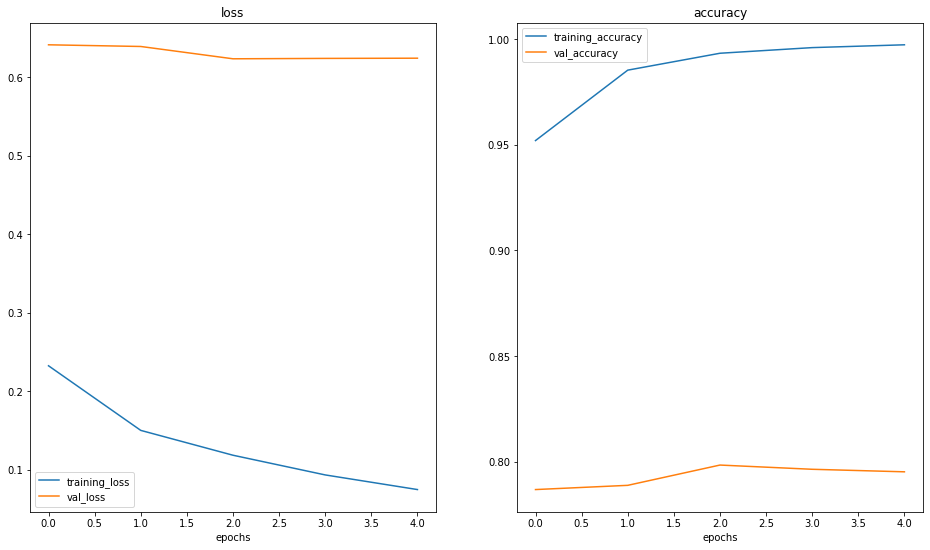

In [ ]:
plot_loss_curves(history_1)

In [ ]:
effnet_model = create_model(model_url = efficientnet_url,
                            num_classes = train_data_10_percent.num_classes)
effnet_model.summary()      


effnet_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ['accuracy'])

history_2 = effnet_model.fit(train_data_10_percent,
                             steps_per_epoch = len(train_data_10_percent),
                             epochs = 5,
                             validation_data = test_data_10_percent,
                             validation_steps = len(test_data_10_percent),
                             callbacks = [create_tensorboard_callback(dir_name = 'tensorflow_hub',
                                                                       experiment_name = 'efficient_net')])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________
Saving TensorBoard log files to : tensorflow_hub/efficient_net/20220111-122443
Epoch 1/5
24/24 [==============================] - 33s 874ms/step - loss: 1.8877 - accuracy: 0.3947 - val_loss: 1.3084 - val_accuracy: 0.7472
Epoch 2/5
24/24 [==============================] - 18s 789ms/step - loss: 1.0723 - accuracy: 0.7907 - val_loss: 0.8623 - val_accuracy: 0.8208
Epoch 

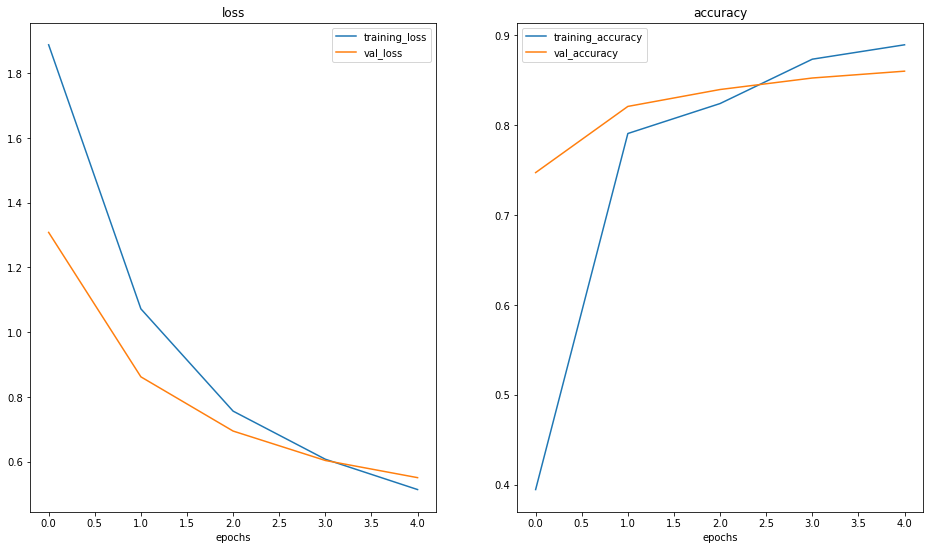

In [ ]:
plot_loss_curves(history_2)

In [ ]:
effnet_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
len(effnet_model.layers[0].weights)

309

In [ ]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


## Different types of transfer learnings

* As is 'transfer learning' - using an existing model with no changes what so ever.
* Efficient  extraction ' transfer learning' - adjust output layer for your problem.
*Fine-tuning 'transfer learning' - use the prelearned patterns of an existing model and 'fine-tune' many or all of the underlying layers (including new output layers)

### Comparing our models results with TensorBoard

> When you upload things to TensoBoard.dev your experiments are public.

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
--name "EfficientNetB0 vs. ResNet50V2" \
--description "Comparing two different TF hub feature extraction model architecture using 10% of the training data" \
--one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/bzQmn0dBSe29FdDE5OLEiQ/

[2022-01-11T12:40:48] Started scanning logdir.
[2022-01-11T12:40:52] Total uploaded: 90 scalars, 0 tensors, 4 binary objects (8.8 MB)
[2022-01-11T12:40:52] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/bzQmn0dBSe29FdDE5OLEiQ/


Our TensorBoard are uploaded here :
https://tensorboard.dev/experiment/MBDbcrjeQVOgdBOOQ7jocQ/

In [ ]:
!tensorboard dev list

https://tensorboard.dev/experiment/4m0JHZZyTVGZKTgTOl7pYA/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF hub feature extraction model architecture using 10% of the training data
	Id                   4m0JHZZyTVGZKTgTOl7pYA
	Created              2022-01-11 12:40:40 (2 minutes ago)
	Updated              2022-01-11 12:40:41 (2 minutes ago)
	Runs                 2
	Tags                 1
	Scalars              0
	Tensor bytes         0
	Binary object bytes  1723166
https://tensorboard.dev/experiment/MBDbcrjeQVOgdBOOQ7jocQ/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF hub feature extraction model architecture using 10% of the training data
	Id                   MBDbcrjeQVOgdBOOQ7jocQ
	Created              2022-01-11 12:36:54 (5 minutes ago)
	Updated              2022-01-11 12:36:58 (5 minutes ago)
	Runs                 7
	Tags                 5
	Scalars              90
	Tensor bytes

In [ ]:
# Delete an experiment
#!tensorboard dev delete --experiment_id bzQmn0dBSe29FdDE5OLEiQ

Deleted experiment bzQmn0dBSe29FdDE5OLEiQ.
